## Import dependecies and define fuctions

In [92]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
from scipy.optimize import curve_fit, fsolve
from scipy import interpolate
from scipy.stats import chisquare, chi2_contingency

from sklearn.metrics import r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import warnings
warnings.filterwarnings("ignore")

# install lmfit regression module
#! pip install lmfit
from lmfit.models import ConstantModel, StepModel
from lmfit import Model, Minimizer, Parameters, report_fit

## Equilibrium fuction

In [93]:
def equilibrium(time_s, elements, errors):
    results = []
    for i, j in zip(elements, errors):
    # assigne x and y values
        x = time_s
        y = df[i].to_numpy()*0.01
        y_err = df[j].to_numpy()*0.01
        #print ("\nelement", i)

        # Equilibrium concentration with 1/3 
        # A : rate_constant, to: onset of the time Ceq:eqilibrium concentraion
        # r =1/3
        r=1/3

        # define power function
        def power(x, A, Ceq):
            return A*(x)**(-r)+Ceq

        # fitting power plot with 2sigma
        popt, pcov = curve_fit(power, x, y, bounds=([-100, 0], [1000, 100]), sigma=y_err) 
        #print("Popt:", popt)
        #print("pcov: ", pcov)
        #print("A =", popt[0], "+/-", pcov[0,0]**0.5)
        #print("Ceq =", popt[1], "+/-", pcov[1,1]**0.5)
        results.append((i, "A =", round(popt[0],5), "+/-", round(pcov[0,0]**0.5,5), "Ceq =", round(popt[1],5),"+/-", round(pcov[1,1]**0.5,5)))

    print("\nEquilibrium Concentrations")
    # print stored data of equiilbrium concentration 
    print("Ceq_Al:", results[0][6], "+/-", results[0][8])
    print("Ceq_Cr:", results[1][6], "+/-", results[1][8])
    print("Ceq_Re:", results[2][6], "+/-", results[2][8])
    Ni = 1- results[0][6] - results[1][6] -results[2][6]
    Ni_err = ((results[0][8])**2 + (results[1][8])**2 + (results[2][8])**2)**0.5
    print("Ceq_Ni:", Ni,"+/-", round(Ni_err, 5))

    print("\nList(Al, Cr, Re)")
    eq_conc = [results[0][6], results[1][6], results[2][6]]
    eq_concerr = [results[0][8], results[1][8], results[2][8]]
    print(eq_conc)
    print(eq_concerr)
    return {'eq_conc':eq_conc,'eq_concerr':eq_concerr}

# Gamma (f.c.c) phase
## Import data

In [94]:
# import csv data
df0= pd.read_csv("C:/Users/jeja9/APTanalysis/Interfacial_width/Re700/supersaturation/gamma_supersaturation700.csv") 
df0= df0.iloc[1:8]
print(f"shape {df0.shape}\n")
df = df0.iloc[2:8]
df

shape (7, 10)



,time_h,time_s,G_Ni,G_Nierr,G_Al,G_Alerr,G_Cr,G_Crerr,G_Re,G_Reerr
3,4,14400,79.833756,0.081898,6.684982,0.050628,10.991558,0.063892,2.489703,0.031652
4,16,57600,79.981063,0.057273,5.935903,0.033609,11.431545,0.045644,2.651489,0.023143
5,64,230400,80.023038,0.041180,5.757687,0.024353,11.444881,0.034112,2.774394,0.016691
6,256,921600,80.077166,0.034407,5.585202,0.019892,11.554927,0.027447,2.782705,0.014183
7,1024,3686400,80.125432,0.053380,5.437891,0.030130,11.636776,0.041616,2.799900,0.021397


## Equilibrium concentrations for Gamma (f.c.c.) phase

### assign x, y, y_err

In [95]:
# Al, Cr, Re equilbrium concentration using for-loop 
#define elements and errors
time_s = df['time_s'].to_numpy()
elements = ['G_Al', 'G_Cr', 'G_Re']
errors = ['G_Alerr', 'G_Crerr', 'G_Reerr']

#calculate the equilibrium composition using fuction equilibrium
eq_concentration = equilibrium(time_s, elements, errors)
eq_concentration


Equilibrium Concentrations
Ceq_Al: 0.05236 +/- 0.00067
Ceq_Cr: 0.11728 +/- 0.00056
Ceq_Re: 0.02882 +/- 0.00026
Ceq_Ni: 0.80154 +/- 0.00091

List(Al, Cr, Re)
[0.05236, 0.11728, 0.02882]
[0.00067, 0.00056, 0.00026]


{'eq_conc': [0.05236, 0.11728, 0.02882],
 'eq_concerr': [0.00067, 0.00056, 0.00026]}

In [96]:
Al_eq_conc = eq_concentration['eq_conc'][0]
Al_eq_conc

0.05236

## Supersatration and fitting for Al, Cr, Re

In [97]:
# define fuction for fitting for three elements Al, Cr, Re
def fitting_value(x, y, y_err, Ceq):
    
    def power(x, A, r):
        return A*(x)**(-r)+Ceq

    # fitting power plot with 2sigma
    popt, pcov = curve_fit(power, x, y, bounds=([-0.5, 0.2000], [0.5000, 0.4000]), method='trf', sigma=y_err) 
    print("\nA =", round(popt[0], 4), "+/-", pcov[0,0]**0.5)
    print("r =", round(popt[1], 4), "+/-", pcov[1,1]**0.5)
    print("1/r =", round(1/popt[1], 4), "+/-", ((1/popt[1])*(pcov[1,1]/popt[1]))**0.5)
    A = popt[0]
    r = popt[1]

    # Calcualte the R_squared value
    best_fit = A*(x)**(-r)+Ceq
    Rsquared = round(r2_score(y, best_fit), 4)
    print(f"R_2: {Rsquared}")
    #ch2, pval = chisquare(y, best_fit)
    ch2 = ((y - best_fit)**2/y_err**2).sum()
    print('chisquare for normdiscrete: chi2 = %6.3e' % (ch2))
    #print('chisquare for normdiscrete: chi2 = %6.3e pvalue = %10.4e' % (ch2, pval))

    # model_fit with fine scale
    xfine = np.linspace(900, max(x), 10000) 
    f2 = A*(xfine)**(-r)+Ceq

    return {'A':A,'r':r, 'best_fit':best_fit, 'Rsquared':Rsquared,'chi2':ch2, 'xfine':xfine, 'f2':f2 }

In [98]:
# Setup the element, error, and equilibrium concentration list
elements = ['G_Al', 'G_Cr', 'G_Re']
errors = ['G_Alerr', 'G_Crerr', 'G_Reerr']
eq_conc = eq_concentration['eq_conc']
eq_concerr = eq_concentration['eq_concerr']

In [99]:
# obtain a fitting value for Al, Cr, Re using for-loop
# A : rate constant, r = exponent, Rsqure = fitting accuracy
A_list = []
r_list = []
Rsqured_list = []
chisqured_list =[]
bestfit_values= []
for i, j, k in zip(elements, errors, eq_conc):
# assigne x and y values
    x0 = df0['time_s'].to_numpy()
    y0 = df0[i].to_numpy()*0.01
    y0_err = df0[j].to_numpy()*0.01
    x = df['time_s'].to_numpy()
    y = df[i].to_numpy()*0.01
    y_err = df[j].to_numpy()*0.01
    Ceq = k
    
    # print the fitting values
    print ("\n", i,"_eqilibrium: ", k)
    values = fitting_value(x, y, y_err, Ceq)
    A_list.append(values['A'])
    r_list.append(values['r'])
    Rsqured_list.append(values['Rsquared'])
    chisqured_list.append(values['chi2'])
    bestfit_values.append(values['best_fit'])


 G_Al _eqilibrium:  0.05236

A = 0.361 +/- 0.16102805174142704
r = 0.3445 +/- 0.03937021588255043
1/r = 2.9029 +/- 0.11428823949344265
R_2: 0.9678
chisquare for normdiscrete: chi2 = 2.211e+01

 G_Cr _eqilibrium:  0.11728

A = -0.1807 +/- 0.1348838931528666
r = 0.3457 +/- 0.06656094480044322
1/r = 2.8927 +/- 0.19253787865792657
R_2: 0.9211
chisquare for normdiscrete: chi2 = 8.628e+00

 G_Re _eqilibrium:  0.02882

A = -0.1148 +/- 0.06952890731464245
r = 0.357 +/- 0.054402084333497795
1/r = 2.8008 +/- 0.15237188049786732
R_2: 0.965
chisquare for normdiscrete: chi2 = 6.951e+00


In [100]:
# Check the value
print ("Rate_constants [Al, Cr, Re]: ",A_list)
print ("Exponents [Al, Cr, Re]: ",r_list)
print ("Rsqured values [Al, Cr, Re]: ",Rsqured_list)
print ("Chisqured values [Al, Cr, Re]: ",chisqured_list)
print ("fit_values",bestfit_values)

Rate_constants [Al, Cr, Re]:  [0.36100210662023613, -0.18072378513280565, -0.11476920149717795]
Exponents [Al, Cr, Re]:  [0.3444817774519076, 0.34570311704066853, 0.35703493423945265]
Rsqured values [Al, Cr, Re]:  [0.9678, 0.9211, 0.965]
Chisqured values [Al, Cr, Re]:  [22.105786089058824, 8.62844678801566, 6.951274608179911]
fit_values [array([0.06569612, 0.06063239, 0.05749136, 0.05554298, 0.0543344 ]), array([0.11068133, 0.11319377, 0.1147496 , 0.11571305, 0.11630967]), array([0.02506037, 0.02652814, 0.02742289, 0.02796832, 0.02830082])]


In [101]:
values['A']

-0.11476920149717795

In [102]:
print (values['xfine'])
print (values['f2'])

[9.00000000e+02 1.26858686e+03 1.63717372e+03 ... 3.68566283e+06
 3.68603141e+06 3.68640000e+06]
[0.01870286 0.01986982 0.02064889 ... 0.02830078 0.0283008  0.02830082]


## Plotting the experimental and model values for Al, Cr, Re


 G_Al _eqilibrium:  0.05236

A = 0.361 +/- 0.16102805174142704
r = 0.3445 +/- 0.03937021588255043
1/r = 2.9029 +/- 0.11428823949344265
R_2: 0.9678
chisquare for normdiscrete: chi2 = 2.211e+01

 G_Cr _eqilibrium:  0.11728

A = -0.1807 +/- 0.1348838931528666
r = 0.3457 +/- 0.06656094480044322
1/r = 2.8927 +/- 0.19253787865792657
R_2: 0.9211
chisquare for normdiscrete: chi2 = 8.628e+00

 G_Re _eqilibrium:  0.02882

A = -0.1148 +/- 0.06952890731464245
r = 0.357 +/- 0.054402084333497795
1/r = 2.8008 +/- 0.15237188049786732
R_2: 0.965
chisquare for normdiscrete: chi2 = 6.951e+00


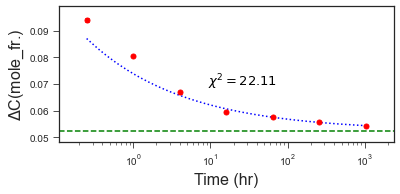

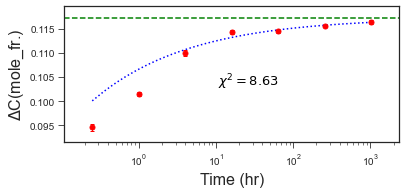

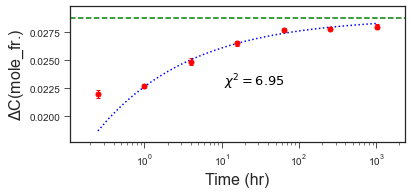

In [103]:
for i, j, k in zip(elements, errors, eq_conc):
# assigne x and y values
    x0 = df0['time_s'].to_numpy()
    y0 = df0[i].to_numpy()*0.01
    y0_err = df0[j].to_numpy()*0.01
    x = df['time_s'].to_numpy()
    y = df[i].to_numpy()*0.01
    y_err = df[j].to_numpy()*0.01
    Ceq = k
    
    # print the fitting values
    print ("\n", i,"_eqilibrium: ", k)
    values = fitting_value(x, y, y_err, Ceq)

    #time scale from second to hour
    x0b = x0/3600
    xfineb = values['xfine']/3600
    f2b = values['f2']

    #plotting
    fig, ax = plt.subplots(figsize=(6,2.5))
    ax.errorbar(x0b, y0, y0_err, fmt='r.', markersize=10, elinewidth=1, capsize=2,label='experiment')
    ax.plot(xfineb, f2b, 'b:', label=r'fitting')
    ax.axhline(y=Ceq, color='g', linestyle='--', label='equilibrium')
    #ax.legend(loc='best', fontsize=13)
    plt.xlabel("Time (hr)", fontsize=16)
    plt.ylabel(r'$\Delta$C(mole_fr.)', fontsize=16)
    #plt.text(0,0, 'Sum of vales = %s\n Total number of entries = %s\n Avg= %s \n Standard Deviation = %s' % (S, N, avg, sigma))
    plt.text(0.55, 0.45, r'$\chi^2={:4.2f}$'.format(values['chi2']), ha='center', va='center', transform=ax.transAxes, color="k", fontsize=13)
    #plt.yscale("log")
    plt.margins(0.1)
    plt.xscale("log")




 G_Al _eqilibrium:  0.05236

A = 0.361 +/- 0.16102805174142704
r = 0.3445 +/- 0.03937021588255043
1/r = 2.9029 +/- 0.11428823949344265
R_2: 0.9678
chisquare for normdiscrete: chi2 = 2.211e+01


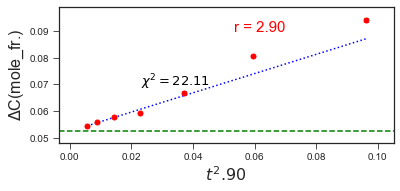


 G_Cr _eqilibrium:  0.11728

A = -0.1807 +/- 0.1348838931528666
r = 0.3457 +/- 0.06656094480044322
1/r = 2.8927 +/- 0.19253787865792657
R_2: 0.9211
chisquare for normdiscrete: chi2 = 8.628e+00


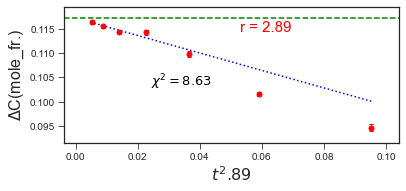


 G_Re _eqilibrium:  0.02882

A = -0.1148 +/- 0.06952890731464245
r = 0.357 +/- 0.054402084333497795
1/r = 2.8008 +/- 0.15237188049786732
R_2: 0.965
chisquare for normdiscrete: chi2 = 6.951e+00


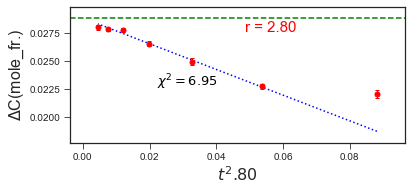

In [104]:
for i, j, k in zip(elements, errors, eq_conc):
# assigne x and y values
    x0 = df0['time_s'].to_numpy()
    y0 = df0[i].to_numpy()*0.01
    y0_err = df0[j].to_numpy()*0.01
    x = df['time_s'].to_numpy()
    y = df[i].to_numpy()*0.01
    y_err = df[j].to_numpy()*0.01
    Ceq = k
    
    # print the fitting values
    print ("\n", i,"_eqilibrium: ", k)
    values = fitting_value(x, y, y_err, Ceq)

    #time scale from second to hour
    r = 1/values['r']
    x0b = x0**(-1/r)
    xfineb = (values['xfine'])**(-1/r)
    f2b = values['f2']
    Rsquared =values['Rsquared']
    Chisquared =values['chi2']

    #plotting
    fig, ax = plt.subplots(figsize=(6,2.5))
    ax.errorbar(x0b, y0, y0_err, fmt='r.', markersize=10, elinewidth=1, capsize=2,label='experiment')
    ax.plot(xfineb, f2b, 'b:', label=r'fitting')
    ax.axhline(y=Ceq, color='g', linestyle='--', label='equilibrium')
    plt.xlabel(r'$t^{:4.2f}$'.format(r), fontsize=16)
    plt.ylabel(r'$\Delta$C(mole_fr.)', fontsize=16)
    #plt.text(0,0, 'Sum of vales = %s\n Total number of entries = %s\n Avg= %s \n Standard Deviation = %s' % (S, N, avg, sigma))
    ax.text(0.6, 0.85, r'r = {:4.2f}'.format(r), ha='center', va='center', transform=ax.transAxes, size=15, color='red')
    plt.text(0.35, 0.45, r'$\chi^2={:4.2f}$'.format(Chisquared), ha='center', va='center', transform=ax.transAxes, color="k", fontsize=13)
    #plt.yscale("log")
    plt.margins(0.1)
    plt.show()



## Plot with four expoents (r) = 2, 2.4, 3, and 4

In [13]:
## define fuction for fitting_with_r values

def fitting_withr(x, y, y_err, r, Ceq):
    
    r = r 
    Ceq = Ceq
    def power1(x, A):
        return A*(x)**(-r)+Ceq

    # fitting power plot with 2sigma
    popt, pcov = curve_fit(power1, x, y, bounds=([-2], [2]), method='trf', sigma=y_err) 
    print("\nA =", round(popt[0], 4), "+/-", pcov[0,0]**0.5)
    #print("r =", round(popt[1], 4), "+/-", pcov[1,1]**0.5)
    #print("1/r =", round(1/popt[1], 4), "+/-", pcov[1,1]**0.5)
    
    A = popt[0]
    #r = round(popt[1], 4)

    # Calcualte the R_squared value
    best_fit = A*(x)**(-r)+Ceq
    Rsquared = round(r2_score(y, best_fit), 4)
    print(f"R_2: {Rsquared}")
    ch2 = ((y - best_fit)**2/y_err**2).sum()
    print('chisquare for normdiscrete: chi2 = %6.3e' % (ch2))
    #ch2, pval = chisquare(y, best_fit)
    #print('chisquare for normdiscrete: chi2 = %6.3e pvalue = %10.4e' % (ch2, pval))

    # model_fit with fine scale
    xfine = np.linspace(900, max(x), 10000) 
    f2 = A*(xfine)**(-r)+Ceq

    return {'A':A,'r':r, 'best_fit':best_fit, 'Rsquared':Rsquared,'chi2':ch2, 'xfine':xfine, 'f2':f2 }



 G_Al _eqilibrium:  0.05236

Exponent value(r):  2

A = 1.9235 +/- 0.2286132703061116
R_2: 0.9145
chisquare for normdiscrete: chi2 = 1.104e+02


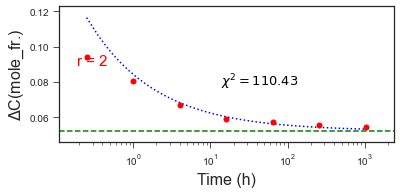


Exponent value(r):  2.4

A = 0.7983 +/- 0.05849376610411452
R_2: 0.9668
chisquare for normdiscrete: chi2 = 4.341e+01


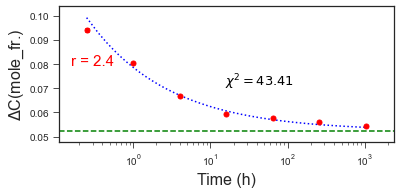


Exponent value(r):  3

A = 0.3184 +/- 0.016769972098201743
R_2: 0.9624
chisquare for normdiscrete: chi2 = 2.266e+01


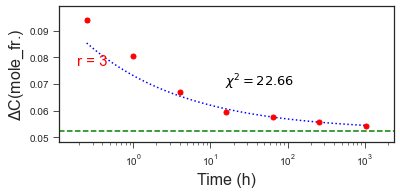


Exponent value(r):  4

A = 0.121 +/- 0.010829355317431042
R_2: 0.8595
chisquare for normdiscrete: chi2 = 6.407e+01


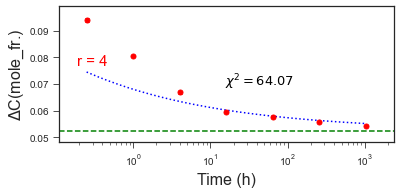



 G_Cr _eqilibrium:  0.11728

Exponent value(r):  2

A = -0.9357 +/- 0.127553437171687
R_2: 0.8961
chisquare for normdiscrete: chi2 = 1.996e+01


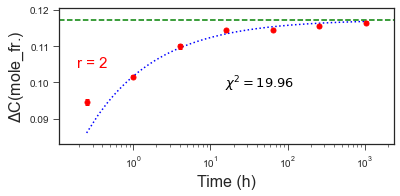


Exponent value(r):  2.4

A = -0.3912 +/- 0.03959638461015502
R_2: 0.9291
chisquare for normdiscrete: chi2 = 1.135e+01


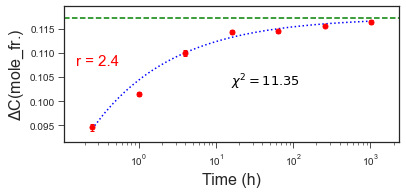


Exponent value(r):  3

A = -0.1574 +/- 0.013897709105680502
R_2: 0.9146
chisquare for normdiscrete: chi2 = 8.720e+00


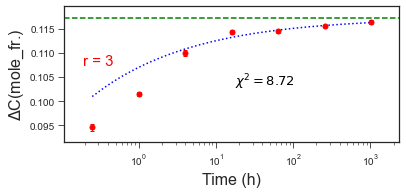


Exponent value(r):  4

A = -0.0604 +/- 0.006949171055805338
R_2: 0.8165
chisquare for normdiscrete: chi2 = 1.452e+01


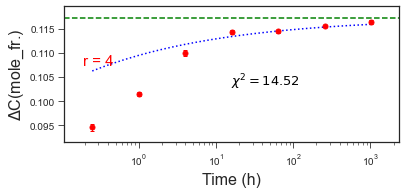



 G_Re _eqilibrium:  0.02882

Exponent value(r):  2

A = -0.5246 +/- 0.06165752032732381
R_2: 0.8962
chisquare for normdiscrete: chi2 = 1.875e+01


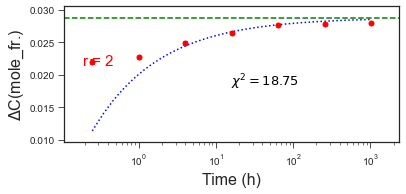


Exponent value(r):  2.4

A = -0.2192 +/- 0.017859892804166954
R_2: 0.9549
chisquare for normdiscrete: chi2 = 9.262e+00


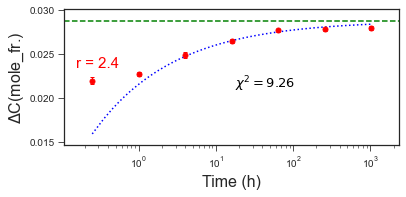


Exponent value(r):  3

A = -0.0882 +/- 0.006384002435357514
R_2: 0.9578
chisquare for normdiscrete: chi2 = 7.352e+00


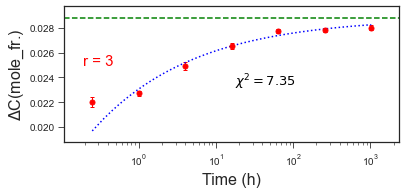


Exponent value(r):  4

A = -0.0338 +/- 0.0036158159637557363
R_2: 0.8636
chisquare for normdiscrete: chi2 = 1.563e+01


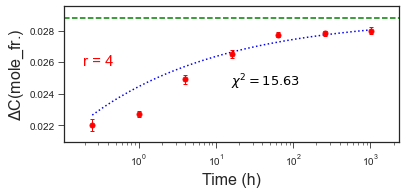

In [14]:
# for different r values ()
# Setup the element, error, and equilibrium concentration list

time_s = df['time_s'].to_numpy()
elements = ['G_Al', 'G_Cr', 'G_Re']
errors = ['G_Alerr', 'G_Crerr', 'G_Reerr']
eq_conc = eq_concentration['eq_conc']
eq_concerr = eq_concentration['eq_concerr']


for i, j, k in zip(elements, errors, eq_conc):
# assigne x and y values
    x0 = df0['time_s'].to_numpy()
    y0 = df0[i].to_numpy()*0.01
    y0_err = df0[j].to_numpy()*0.01
    x = df['time_s'].to_numpy()
    y = df[i].to_numpy()*0.01
    y_err = df[j].to_numpy()*0.01
    Ceq = k
    print ("\n\n", i,"_eqilibrium: ", k)
    
    for n in [2, 2.4, 3, 4]:
        # print the fitting values
        print ("\nExponent value(r): ", n)
        r = 1/n
        values_wor = fitting_withr(x, y, y_err, r, Ceq)

        #time scale from second to hour
        x0b = x0/3600
        xfineb = values_wor['xfine']/3600
        f2b = values_wor['f2']
        Rsquared =values_wor['Rsquared']
        Chisquared =values_wor['chi2']
        
        #plotting
        fig, ax = plt.subplots(figsize=(6,2.5))
        ax.errorbar(x0b, y0, y0_err, fmt='r.', markersize=10, elinewidth=1, capsize=2,label='experiment')
        ax.plot(xfineb, f2b, 'b:', label=r'fitting')
        ax.axhline(y=Ceq, color='g', linestyle='--', label='equilibrium')
        #ax.legend(loc='best', fontsize=13)
        plt.xlabel("Time (h)", fontsize=16)
        plt.ylabel(r'$\Delta$C(mole_fr.)', fontsize=16)
        #plt.text(0,0, 'Sum of vales = %s\n Total number of entries = %s\n Avg= %s \n Standard Deviation = %s' % (S, N, avg, sigma))
        ax.text(0.1, 0.6, r'r = {}'.format(n), ha='center', va='center', transform=ax.transAxes, size=15, color='red')
        plt.text(0.6, 0.45, r'$\chi^2={:4.2f}$'.format(Chisquared), ha='center', va='center', transform=ax.transAxes, color="k", fontsize=13)
        #plt.yscale("log")
        plt.margins(0.1)
        plt.xscale("log")
        plt.show()
        #plt.savefig("test.png")


## Linear fitting with exponent value of aging time



 G_Al _eqilibrium:  0.05236

Exponent value(r):  2

A = 1.9235 +/- 0.2286132703061116
R_2: 0.9145
chisquare for normdiscrete: chi2 = 1.104e+02


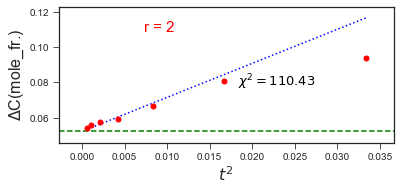


Exponent value(r):  2.4

A = 0.7983 +/- 0.05849376610411452
R_2: 0.9668
chisquare for normdiscrete: chi2 = 4.341e+01


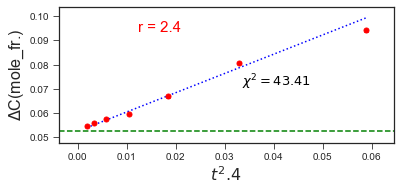


Exponent value(r):  3

A = 0.3184 +/- 0.016769972098201743
R_2: 0.9624
chisquare for normdiscrete: chi2 = 2.266e+01


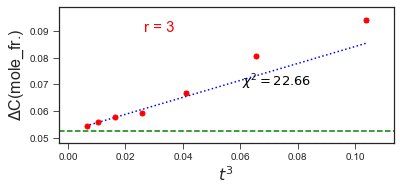


Exponent value(r):  4

A = 0.121 +/- 0.010829355317431042
R_2: 0.8595
chisquare for normdiscrete: chi2 = 6.407e+01


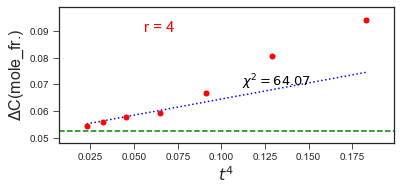



 G_Cr _eqilibrium:  0.11728

Exponent value(r):  2

A = -0.9357 +/- 0.127553437171687
R_2: 0.8961
chisquare for normdiscrete: chi2 = 1.996e+01


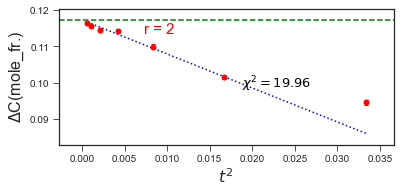


Exponent value(r):  2.4

A = -0.3912 +/- 0.03959638461015502
R_2: 0.9291
chisquare for normdiscrete: chi2 = 1.135e+01


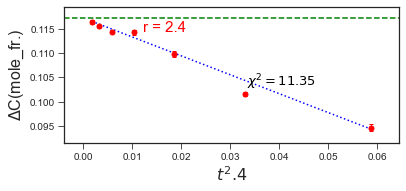


Exponent value(r):  3

A = -0.1574 +/- 0.013897709105680502
R_2: 0.9146
chisquare for normdiscrete: chi2 = 8.720e+00


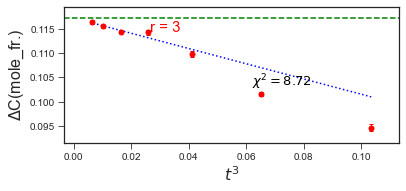


Exponent value(r):  4

A = -0.0604 +/- 0.006949171055805338
R_2: 0.8165
chisquare for normdiscrete: chi2 = 1.452e+01


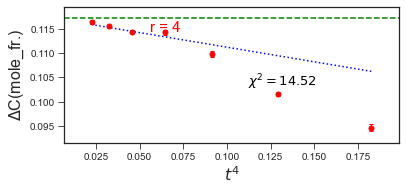



 G_Re _eqilibrium:  0.02882

Exponent value(r):  2

A = -0.5246 +/- 0.06165752032732381
R_2: 0.8962
chisquare for normdiscrete: chi2 = 1.875e+01


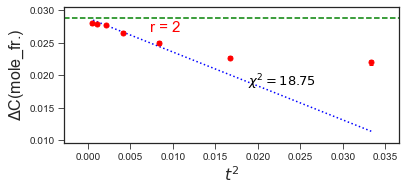


Exponent value(r):  2.4

A = -0.2192 +/- 0.017859892804166954
R_2: 0.9549
chisquare for normdiscrete: chi2 = 9.262e+00


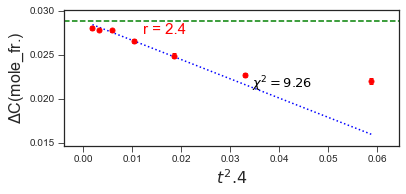


Exponent value(r):  3

A = -0.0882 +/- 0.006384002435357514
R_2: 0.9578
chisquare for normdiscrete: chi2 = 7.352e+00


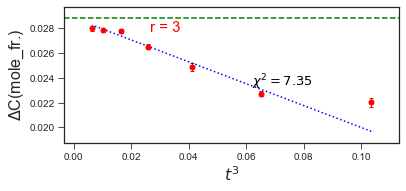


Exponent value(r):  4

A = -0.0338 +/- 0.0036158159637557363
R_2: 0.8636
chisquare for normdiscrete: chi2 = 1.563e+01


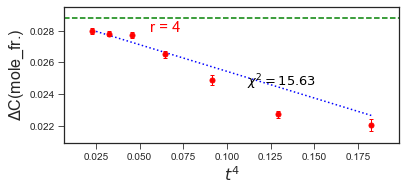

In [15]:
# for different r values ()

time_s = df['time_s'].to_numpy()
elements = ['G_Al', 'G_Cr', 'G_Re']
errors = ['G_Alerr', 'G_Crerr', 'G_Reerr']
eq_conc = eq_concentration['eq_conc']
eq_concerr = eq_concentration['eq_concerr']

for i, j, k in zip(elements, errors, eq_conc):
# assigne x and y values
    x0 = df0['time_s'].to_numpy()
    y0 = df0[i].to_numpy()*0.01
    y0_err = df0[j].to_numpy()*0.01
    x = df['time_s'].to_numpy()
    y = df[i].to_numpy()*0.01
    y_err = df[j].to_numpy()*0.01
    Ceq = k
    print ("\n\n", i,"_eqilibrium: ", k)
    
    for n in [2, 2.4, 3, 4]:
        # print the fitting values
        print ("\nExponent value(r): ", n)
        r = 1/n
        values_wor = fitting_withr(x, y, y_err, r, Ceq)
        
        #time scale from second to hour
        x0b = x0**(-r)
        xfineb = (values_wor['xfine'])**(-r)
        f2b = values_wor['f2']
        Rsquared =values_wor['Rsquared']
        Chisquared =values_wor['chi2']
        
        #plotting
        fig, ax = plt.subplots(figsize=(6,2.5))
        ax.errorbar(x0b, y0, y0_err, fmt='r.', markersize=10, elinewidth=1, capsize=2,label='experiment')
        ax.plot(xfineb, f2b, 'b:', label=r'fitting')
        ax.axhline(y=Ceq, color='g', linestyle='--', label='equilibrium')
        plt.xlabel(r'$t^{}$'.format(n), fontsize=16)
        plt.ylabel(r'$\Delta$C(mole_fr.)', fontsize=16)
        #plt.text(0,0, 'Sum of vales = %s\n Total number of entries = %s\n Avg= %s \n Standard Deviation = %s' % (S, N, avg, sigma))
        ax.text(0.3, 0.85, r'r = {}'.format(n), ha='center', va='center', transform=ax.transAxes, size=15, color='red')
        plt.text(0.65, 0.45, r'$\chi^2={:4.2f}$'.format(Chisquared), ha='center', va='center', transform=ax.transAxes, color="k", fontsize=13)
        #plt.yscale("log")
        plt.margins(0.1)
        plt.show()
        #plt.savefig("test.png")



 G_Al _eqilibrium:  0.05236
R_squred_max 0.9743
2.6236236236236237
0.38115223197252956


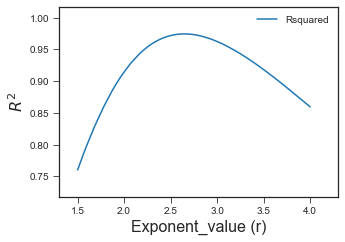

Chi_squred_min 22.105847592968576
2.903903903903904
0.344364012409514


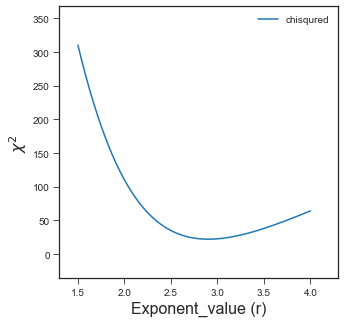



 G_Cr _eqilibrium:  0.11728
R_squred_max 0.9313
2.531031031031031
0.39509590666403005


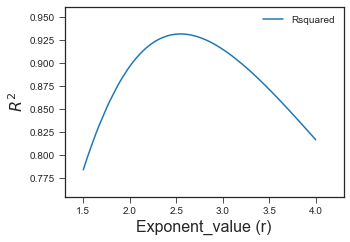

Chi_squred_min 8.628459781356613
2.893893893893894
0.3455551712210308


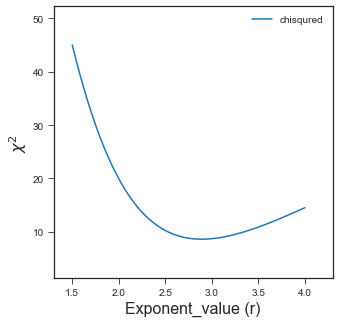



 G_Re _eqilibrium:  0.02882
R_squred_max 0.966
2.681181181181181
0.3729699458652231


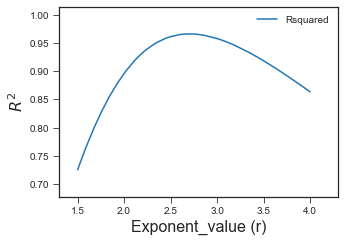

Chi_squred_min 6.951276968225969
2.8013013013013013
0.3569769519385385


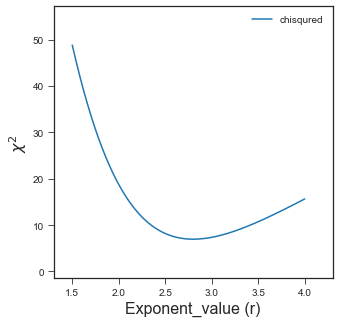

In [57]:
# define fuction for fitting for three elements Al, Cr, Re
## define fuction for fitting_with_r values

def fitting_withr(x, y, y_err, r, Ceq):
    
    def power2(x, A):
        return A*(x)**(-r)+Ceq

    # fitting power plot with 2sigma
    popt, pcov = curve_fit(power2, x, y, sigma=y_err) 
    #print("A =", round(popt[0], 4), "+/-", pcov[0,0]**0.5)

    A = popt[0]

    # Calcualte the R_squared value
    best_fit = A*(x)**(-r)+Ceq
    Rsquared = round(r2_score(y, best_fit), 4)
    #print(f"R_2: {Rsquared}")
    ch2 = ((y - best_fit)**2/y_err**2).sum()
    #print('chisquare for normdiscrete: chi2 = %6.3e' % (ch2))
    #ch2, pval = chisquare(y, best_fit)
    #print('chisquare for normdiscrete: chi2 = %6.3f pvalue = %6.4f' % (ch2, pval))

    # model_fit with fine scale
    xfine = np.linspace(900, max(x), 10000) 
    f2 = A*(xfine)**(-r)+Ceq

    return {'A':A, 'Rsquared':Rsquared, 'chi2':ch2, 'xfine':xfine, 'f2':f2}

# for different r values ()

'''
elements = ['G_Al', 'G_Cr', 'G_Re']
errors = ['G_Alerr', 'G_Crerr', 'G_Reerr']
Al_eq_conc = eq_concentration['eq_conc'][0]

x0 = df0['time_s'].to_numpy()
y0 = df0['G_Al'].to_numpy()*0.01
y0_err = df0['G_Alerr'].to_numpy()*0.01
x = df['time_s'].to_numpy()
y = df['G_Al'].to_numpy()*0.01
y_err = df['G_Alerr'].to_numpy()*0.01
Ceq = Al_eq_conc'''


time_s = df['time_s'].to_numpy()
elements = ['G_Al', 'G_Cr', 'G_Re']
errors = ['G_Alerr', 'G_Crerr', 'G_Reerr']
eq_conc = eq_concentration['eq_conc']
eq_concerr = eq_concentration['eq_concerr']

for i, j, k in zip(elements, errors, eq_conc):
# assigne x and y values
    x0 = df0['time_s'].to_numpy()
    y0 = df0[i].to_numpy()*0.01
    y0_err = df0[j].to_numpy()*0.01
    x = df['time_s'].to_numpy()
    y = df[i].to_numpy()*0.01
    y_err = df[j].to_numpy()*0.01
    Ceq = k
    print ("\n\n", i,"_eqilibrium: ", k)

    rsq_dict ={}
    chi_dict ={}
    for n in np.linspace(1.5, 4, 1000):
        # print the fitting values
        #print ("\nExponent value(r): ", n)
        r = 1/n
        values_wor = fitting_withr(x, y, y_err, r, Ceq)

        #time scale from second to hour
        x0b = x0**(-r)
        xfineb = (values_wor['xfine'])**(-r)
        f2b = values_wor['f2']
        Rsquared =values_wor['Rsquared']
        chisquared =values_wor['chi2']
        rsq_dict[n] =values_wor['Rsquared']
        chi_dict[n] =values_wor['chi2']

    fit_df=pd.DataFrame.from_dict(rsq_dict, orient='index', columns=['Rsquared'])
    print("R_squred_max",fit_df["Rsquared"].max())
    print(fit_df["Rsquared"].idxmax())
    print(1/fit_df["Rsquared"].idxmax())

    ax1 =fit_df.plot(y='Rsquared', kind = 'line', figsize=(5,3.5))
    ax1.set_xlim(1.3, 4.3)
    plt.xlabel("Exponent_value (r)", fontsize=16)
    plt.ylabel( r'$R^2$', fontsize=16)
    plt.margins(0.2)
    plt.show()


    chifit_df=pd.DataFrame.from_dict(chi_dict, orient='index', columns=['chisqured'])
    print("Chi_squred_min",chifit_df["chisqured"].min())
    print(chifit_df["chisqured"].idxmin())
    print(1/chifit_df["chisqured"].idxmin())

    ax2 = chifit_df.plot(y='chisqured', kind = 'line', figsize=(5,5))
    ax2.set_xlim(1.3, 4.3)
    #ax.set_ylim(-5, 5)
    plt.xlabel("Exponent_value (r)", fontsize=16)
    plt.ylabel( r'$\chi^2$', fontsize=16)
    plt.margins(0.2)
    plt.show()

0.966
2.681181181181181
0.3729699458652231


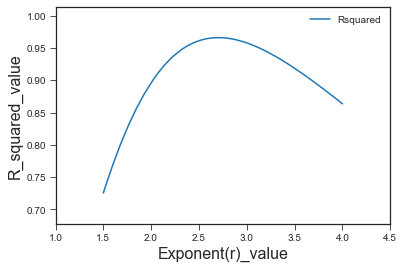

6.951276968225969
2.8013013013013013
0.3569769519385385


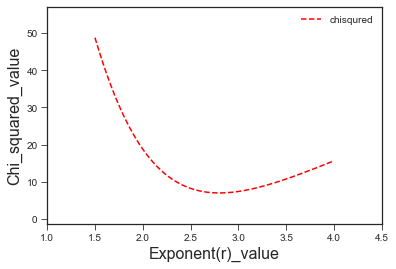

In [18]:
fit_df=pd.DataFrame.from_dict(rsq_dict, orient='index',
                       columns=['Rsquared'])
print(fit_df["Rsquared"].max())
print(fit_df["Rsquared"].idxmax())
print(1/fit_df["Rsquared"].idxmax())

fit_df.plot(y='Rsquared', kind = 'line')
plt.xlabel("Exponent(r)_value", fontsize=16)
plt.ylabel( "R_squared_value", fontsize=16)
plt.margins(0.2)
plt.show()


chifit_df=pd.DataFrame.from_dict(chi_dict, orient='index',
                       columns=['chisqured'])
print(chifit_df["chisqured"].min())
print(chifit_df["chisqured"].idxmin())
print(1/chifit_df["chisqured"].idxmin())

chifit_df.plot(y='chisqured', color='r', linestyle='dashed')
plt.xlabel("Exponent(r)_value", fontsize=16)
plt.ylabel( "Chi_squared_value", fontsize=16)
plt.margins(0.2)
plt.show()

## Linear fitting with t to the power r

In [142]:
def fitting_withr(x, y, y_err, r, Ceq):
        
    t = x**(-r)
    Ceq = Ceq
    def power1(t, A):
        return A*t+Ceq

    # fitting power plot with 2sigma
    popt, pcov = curve_fit(power1, t, y, bounds=([-2], [2]), method='trf', sigma=y_err) 
    #print("\nA =", round(popt[0], 4), "+/-", pcov[0,0]**0.5)
    #print("r =", round(popt[1], 4), "+/-", pcov[1,1]**0.5)
    #print("1/r =", round(1/popt[1], 4), "+/-", pcov[1,1]**0.5)
    
    A = popt[0]
    #r = round(popt[1], 4)

    # Calcualte the R_squared value
    best_fit = A*t+Ceq
    Rsquared = round(r2_score(y, best_fit), 4)
    #print(f"R_2: {Rsquared}")
    ch2 = ((y - best_fit)**2/y_err**2).sum()
    #print('chisquare for normdiscrete: chi2 = %6.3e' % (ch2))
    #ch2, pval = chisquare(y, best_fit)
    #print('chisquare for normdiscrete: chi2 = %6.3e pvalue = %10.4e' % (ch2, pval))

    # model_fit with fine scale
    tfine = np.linspace(2000, 1000000000, 10000)**(-r)
    f2 = A*tfine+Ceq

    return {'A':A,'r':r, 'best_fit':best_fit, 'Rsquared':Rsquared,'chi2':ch2, 'tfine':tfine, 'f2':f2 }


Exponent value(r):  2

Exponent value(r):  2.62362

Exponent value(r):  3

Exponent value(r):  4


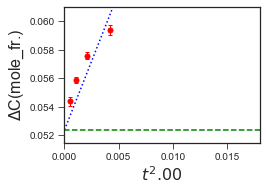

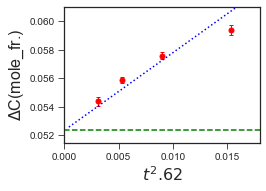

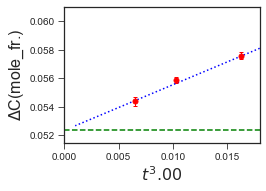

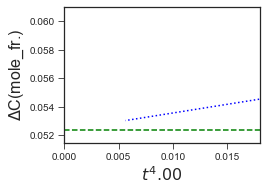

In [149]:
# Linear fitting for Al with four r values ()

elements = ['G_Al', 'G_Cr', 'G_Re']
errors = ['G_Alerr', 'G_Crerr', 'G_Reerr']
Al_eq_conc = eq_concentration['eq_conc'][0]

x0 = df0['time_s'].to_numpy()
y0 = df0['G_Al'].to_numpy()*0.01
y0_err = df0['G_Alerr'].to_numpy()*0.01
x = df['time_s'].to_numpy()
y = df['G_Al'].to_numpy()*0.01
y_err = df['G_Alerr'].to_numpy()*0.01
Ceq = Al_eq_conc


for n in [2, 2.62362, 3, 4]:
    # print the fitting values
    print ("\nExponent value(r): ", n)
    r = 1/n
    values_wor = fitting_withr(x, y, y_err, r, Ceq)

    #time scale from second to hour
    x0b = x0**(-r)
    xfineb = (values_wor['tfine'])
    f2b = values_wor['f2']
    Rsquared =values_wor['Rsquared']
    Chisquared =values_wor['chi2']
    
    #plotting
    fig, ax = plt.subplots(figsize=(3.5,2.5))
    ax.errorbar(x0b, y0, y0_err, fmt='r.', markersize=10, elinewidth=1, capsize=2,label='experiment')
    ax.plot(xfineb, f2b, 'b:', label=r'fitting')
    ax.axhline(y=Ceq, color='g', linestyle='--', label='equilibrium')
    plt.xlabel(r'$t^{:4.2f}$'.format(n), fontsize=16)
    plt.ylabel(r'$\Delta$C(mole_fr.)', fontsize=16)
    #plt.text(0,0, 'Sum of vales = %s\n Total number of entries = %s\n Avg= %s \n Standard Deviation = %s' % (S, N, avg, sigma))
    #ax.text(0.7, 0.86, r'r = {:4.2f}'.format(n), ha='center', va='center', transform=ax.transAxes, size=15, color='red')
    #plt.text(0.5, 0.3, r'$R^2={}$'.format(Rsquared), ha='center', va='center', transform=ax.transAxes, color="k", fontsize=13)
    #plt.yscale("log")
    plt.margins(0.1)
    plt.xlim(0, 0.018)
    plt.ylim(0.0515, 0.061)
    
    #plt.savefig("test.png")



 G_Al _eqilibrium:  0.05236
R_squred_max 0.9743
2.623123123123123
0.3812249570692616


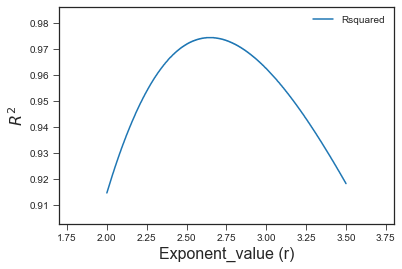

Chi_squred_min 22.105802065356748
2.9024024024024024
0.3445421624418003


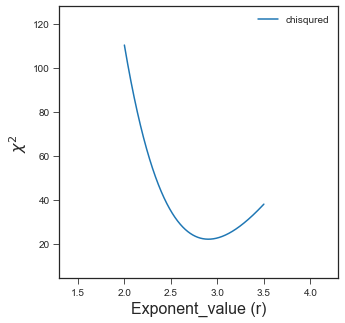



 G_Cr _eqilibrium:  0.11728
R_squred_max 0.9313
2.53003003003003
0.39525222551928785


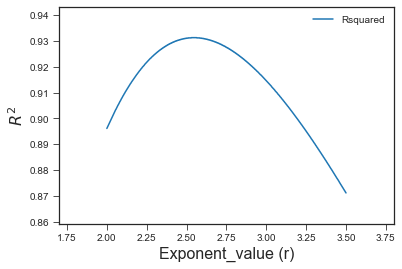

Chi_squred_min 8.628451409341613
2.8933933933933935
0.34561494551115723


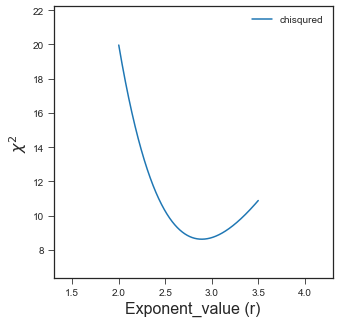



 G_Re _eqilibrium:  0.02882
R_squred_max 0.966
2.6816816816816815
0.3729003359462486


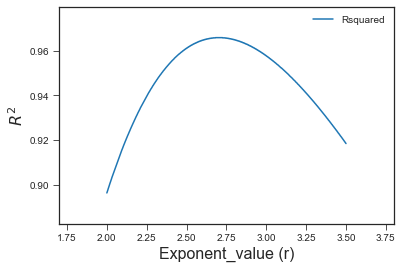

Chi_squred_min 6.951277965687574
2.8003003003003
0.35710455764075066


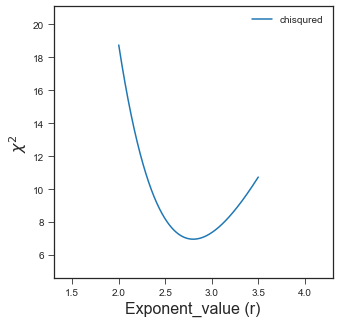

In [141]:
# for different r values ()

time_s = df['time_s'].to_numpy()
elements = ['G_Al', 'G_Cr', 'G_Re']
errors = ['G_Alerr', 'G_Crerr', 'G_Reerr']
eq_conc = eq_concentration['eq_conc']
eq_concerr = eq_concentration['eq_concerr']

for i, j, k in zip(elements, errors, eq_conc):
# assigne x and y values
    x0 = df0['time_s'].to_numpy()
    y0 = df0[i].to_numpy()*0.01
    y0_err = df0[j].to_numpy()*0.01
    x = df['time_s'].to_numpy()
    y = df[i].to_numpy()*0.01
    y_err = df[j].to_numpy()*0.01
    Ceq = k
    print ("\n\n", i,"_eqilibrium: ", k)

    rsq_dict ={}
    chi_dict ={}
    for n in np.linspace(2, 3.5, 1000):
        # print the fitting values
        #print ("\nExponent value(r): ", n)
        r = 1/n
        values_wor = fitting_withr(x, y, y_err, r, Ceq)

        #time scale from second to hour
        x0b = x0**(-r)
        xfineb = (values_wor['tfine'])
        f2b = values_wor['f2']
        Rsquared =values_wor['Rsquared']
        chisquared =values_wor['chi2']
        rsq_dict[n] =values_wor['Rsquared']
        chi_dict[n] =values_wor['chi2']

    fit_df=pd.DataFrame.from_dict(rsq_dict, orient='index', columns=['Rsquared'])
    print("R_squred_max",fit_df["Rsquared"].max())
    print(fit_df["Rsquared"].idxmax())
    print(1/fit_df["Rsquared"].idxmax())

    fit_df.plot(y='Rsquared', kind = 'line')
    plt.xlabel("Exponent_value (r)", fontsize=16)
    plt.ylabel( r'$R^2$', fontsize=16)
    plt.margins(0.2)
    plt.show()


    chifit_df=pd.DataFrame.from_dict(chi_dict, orient='index', columns=['chisqured'])
    print("Chi_squred_min",chifit_df["chisqured"].min())
    print(chifit_df["chisqured"].idxmin())
    print(1/chifit_df["chisqured"].idxmin())

    ax = chifit_df.plot(y='chisqured', kind = 'line', figsize=(5,5))
    ax.set_xlim(1.3, 4.3)
    #ax.set_ylim(-5, 5)
    plt.xlabel("Exponent_value (r)", fontsize=16)
    plt.ylabel( r'$\chi^2$', fontsize=16)
    plt.margins(0.2)
    plt.show()